In [ ]:
import h5py
import glob
import os
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import cooler
import umap
import anndata
import harmonypy as hm
from itertools import cycle, islice

import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph


import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import cooltools.lib.plotting

from scipy import ndimage as nd
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from concurrent.futures import ProcessPoolExecutor, as_completed

from ALLCools.clustering import significant_pc_test

In [ ]:
chrom_size_path = '/projects/ps-renlab2/y2xie/projects/genome_ref/mm10.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

## Coembed using GAD score

In [8]:
### gene score is calculated using schic_gene_score_v2.sh
gene_hdf = pd.read_hdf("../hicluster/imputed_matrix/10kb_resolution/genescore/geneimputescore.hdf", key='data')

In [9]:
res = 10000
gene_meta_path = '/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/mm10/mm10.PairedTag.txt'
gene_meta = pd.read_csv(gene_meta_path, names = ['chrom', 'start', 'end', 'gene_id', 'gene_name'], index_col='gene_id', sep='\s+')
gene_meta['bin_len'] = (gene_meta['end'] // res) - (gene_meta['start'] // res) + 1
gene_meta['weight'] = (gene_meta['bin_len']+2) * (gene_meta['bin_len'] + 1) / 2

In [10]:
chrom_size_path = '/projects/ps-renlab/y2xie/projects/genome_ref/mm10.main.chrom.sizes'
chromsize = pd.read_csv(chrom_size_path, sep='\t', header=None, index_col=0)
gene_meta = gene_meta[gene_meta['chrom'].isin(chromsize.index)]
gene_meta.head()

,chrom,start,end,gene_name,bin_len,weight
gene_id,,,,,,
ENSMUSG00000102693,chr1,3072253,3075322,4933401J01Rik,1,3.0
ENSMUSG00000064842,chr1,3101016,3103125,Gm26206,1,3.0
ENSMUSG00000051951,chr1,3204901,3672498,Xkr4,48,1225.0
ENSMUSG00000102851,chr1,3251757,3254236,Gm18956,1,3.0
ENSMUSG00000103377,chr1,3364731,3369549,Gm37180,1,3.0


In [11]:
gene3c = anndata.AnnData(gene_hdf)
stat = pd.read_csv('../03.mapping/LC462_LC716_mm10.sc.stat.csv', sep = '\t')
tmeta = gene3c.obs.merge(stat, left_index = True, right_on = 'cool_cell')
stat2 = pd.read_csv('metadata/mFC_hicluster_svd50_leiden08.csv', sep = '\t')
tmeta = tmeta.merge(stat2, left_on = 'cool_cell', right_on = 'bc', )
tmeta.index = tmeta['cool_cell']

gene3c = gene3c[tmeta['cool_cell'], :]
gene3c.obs = tmeta
gene3c

/tmp/ipykernel_1074484/2359059993.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gene3c = anndata.AnnData(gene_hdf)


AnnData object with n_obs × n_vars = 6235 × 32195
    obs: 'bc_x', 'total', 'mapped', 'unmapped', 'duplicate', 'cis', 'cis_1kb-', 'cis_1kb+', 'cis_10kb+', 'trans', 'sample', 'cool_cell', 'Unnamed: 0', 'UMAP1', 'UMAP2', 'leiden_08', 'bc_y', 'batch'

In [12]:
genefilter = ((gene3c.X>0).sum(axis=0)>10) & (gene3c.var.index.isin(gene_meta.index))
gene3c = gene3c[:, genefilter]
gene3c

View of AnnData object with n_obs × n_vars = 6235 × 30191
    obs: 'bc_x', 'total', 'mapped', 'unmapped', 'duplicate', 'cis', 'cis_1kb-', 'cis_1kb+', 'cis_10kb+', 'trans', 'sample', 'cool_cell', 'Unnamed: 0', 'UMAP1', 'UMAP2', 'leiden_08', 'bc_y', 'batch'

In [8]:
import scanpy as sc
gene3c.var.index.name = 'gene_id'
gene3c.var.index = gene_meta.loc[gene3c.var.index, 'gene_name']
gene3c.var_names_make_unique()
sc.pp.normalize_total(gene3c, target_sum=np.median(gene3c.X.sum(axis=1)))

tmp = np.std(gene3c.X, axis=0)
from scipy.stats import rankdata
tmp = rankdata(-tmp)
gene3c.var['highly_variable'] = (tmp<2000)
gene3c = gene3c[:, gene3c.var['highly_variable']]

gene3c

/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 6235 × 1999
    obs: 'bc_x', 'total', 'mapped', 'unmapped', 'duplicate', 'cis', 'cis_1kb-', 'cis_1kb+', 'cis_10kb+', 'trans', 'sample', 'cool_cell', 'Unnamed: 0', 'UMAP1', 'UMAP2', 'leiden_08', 'bc_y', 'batch'
    var: 'highly_variable'

In [13]:
import scanpy as sc
gene3c.var.index.name = 'gene_id'
gene3c.var.index = gene_meta.loc[gene3c.var.index, 'gene_name']
gene3c.var_names_make_unique()
sc.pp.normalize_total(gene3c, target_sum=np.median(gene3c.X.sum(axis=1)))

/projects/ps-renlab/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
from scipy.sparse import csr_matrix

gene3c_mtx = csr_matrix(gene3c.X)
gene3c_cells = gene3c.obs.index
gene3c_genes = gene3c.var.index

pd.DataFrame(gene3c_cells).to_csv('../hicluster/imputed_matrix/10kb_resolution/genescore/geneimputescore.barcodes.tsv', sep = '\t')
pd.DataFrame(gene3c_genes).to_csv('../hicluster/imputed_matrix/10kb_resolution/genescore/geneimputescore.genes.tsv', sep = '\t')

In [15]:
### Prevent the use of scientific notation
from scipy.io.mmio import MMFile
class MMFileFixedFormat(MMFile):

    def _field_template(self, field, precision):
        # Override MMFile._field_template.
        return f'%.{precision}f\n'
    
MMFileFixedFormat().write('../hicluster/imputed_matrix/10kb_resolution/genescore/geneimputescore.mtx', gene3c_mtx, precision = 2)

/tmp/ipykernel_1074484/4041834415.py:2: DeprecationWarning: Please use `MMFile` from the `scipy.io` namespace, the `scipy.io.mmio` namespace is deprecated.
  from scipy.io.mmio import MMFile


## Use RNA dim reduction model to transform Hi-C

In [33]:
### use seuratDisk to converet data format
### reference RNA dataset can be found here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE224560
expr = anndata.read_h5ad('../../../public_data/FC_RNA_Seurat_merged_rmScrublet_221229.h5ad')
expr = anndata.AnnData(X=expr.raw.X, obs=expr.obs, var=expr.raw.var, raw=expr.raw, obsm=expr.obsm, uns=expr.uns, obsp=expr.obsp)

/scratch/y2xie/34090333.tscc-mgr7.local/ipykernel_16433/870571811.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  expr = anndata.AnnData(X=expr.raw.X, obs=expr.obs, var=expr.raw.var, raw=expr.raw, obsm=expr.obsm, uns=expr.uns, obsp=expr.obsp)


In [34]:
gene3c = gene3c[:, gene3c.var.index.isin(expr.var.index)]
gene3c

View of AnnData object with n_obs × n_vars = 6235 × 1936
    obs: 'bc_x', 'total', 'mapped', 'unmapped', 'duplicate', 'cis', 'cis_1kb-', 'cis_1kb+', 'cis_10kb+', 'trans', 'sample', 'cool_cell', 'Unnamed: 0', 'UMAP1', 'UMAP2', 'leiden_08', 'bc_y', 'batch', 'Modality'
    var: 'highly_variable', 'mean', 'std'
    obsm: 'X_pca'

In [35]:
tmp = np.std(gene3c.X, axis=0)
from scipy.stats import rankdata
tmp = rankdata(-tmp)
gene3c.var['highly_variable'] = (tmp<2000)
gene3c = gene3c[:, gene3c.var['highly_variable']]

/scratch/y2xie/34090333.tscc-mgr7.local/ipykernel_16433/1215862263.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  gene3c.var['highly_variable'] = (tmp<2000)


In [36]:
expr = expr[:, gene3c.var.index]
sc.pp.regress_out(expr, ['nCount_RNA'])
sc.pp.scale(expr, max_value=10)

from sklearn.decomposition import TruncatedSVD
dim = 50
model = TruncatedSVD(n_components=dim, algorithm='arpack')
matrix_reduce = model.fit_transform(expr.X)
matrix_reduce = matrix_reduce / model.singular_values_

expr.obsm['rna_pca_all'] = matrix_reduce.copy()
significant_pc_test(expr, p_cutoff=0.1, update=False, obsm='rna_pca_all')

/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'sample' as categorical
... storing 'bc' as categorical
... storing 'atac_bc' as categorical
... storing 'arc' as categorical
... storing 'scrublet_ident' as categorical
/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'Anno0.8_yel' as categorical
... storing 'Class' as categorical
/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'Class.color' as categorical
/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/a

26 components passed P cutoff of 0.1.


26

In [86]:
from sklearn.preprocessing import normalize, OneHotEncoder

def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

knn = 25
expr.obsm['X_pca'] = normalize(expr.obsm['rna_pca_all'][:, :30], axis=1)
sc.pp.neighbors(expr, n_neighbors=knn, use_rep='X_pca')
sc.tl.umap(expr, maxiter=200, random_state=0)
expr = dump_embedding(expr, 'umap')
expr.obsm['rna_u30_umap'] = expr.obsm['X_umap'].copy()

In [41]:
### now use the model to transform hic data
sc.pp.regress_out(gene3c, ['mapped'])
sc.pp.scale(gene3c, max_value=10)
gene3c.obsm['X_pca'] = model.transform(gene3c.X) / model.singular_values_
gene3c.obsm['X_pca'] = normalize(gene3c.obsm['X_pca'][:, :30], axis=1)

/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'Modality' as categorical


In [42]:
### run integration
from ALLCools.integration.seurat_class import SeuratIntegration

expr.obs['Modality'] = 'RNA'
gene3c.obs['Modality'] = '3C'
adata_list = [expr, gene3c]
integrator = SeuratIntegration()
anchor = integrator.find_anchor(adata_list,
                                k_local=None,
                                key_local='X_pca',
                                k_anchor=5,
                                key_anchor='X',
                                dim_red='cca',
                                max_cc_cells=50000,
                                k_score=30,
                                k_filter=None,
                                scale1=False,
                                scale2=False,
                                #scale =[False, True]
                                n_components=30,
                                n_features=200,
                                alignments=[[[0], [1]]])

Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=30
Score Anchors
Identified 19519 anchors between datasets 0 and 1.


In [43]:
import time
start_time = time.time()
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=30,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

print(time.time() - start_time)

Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. 

/home/y2xie/anaconda3/envs/seurat/lib/python3.9/site-packages/ALLCools/integration/seurat_class.py:735: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(corrected),


k_weight:  100
Normalize graph
Transform data
15.225693464279175


In [44]:
ncell = np.sum([xx.shape[0] for xx in adata_list])
adata_merge = anndata.AnnData(
    X=np.ones((ncell, 1)), obs=pd.concat([xx.obs for xx in adata_list], axis=0)
)
adata_merge.obsm['u30_seuratcc30nofilter'] = np.concatenate(corrected, axis=0)
adata_merge.obsm['X_pca'] = normalize(adata_merge.obsm['u30_seuratcc30nofilter'][:, :30], axis=1)

knn = 25
sc.pp.neighbors(adata_merge, n_neighbors=knn, use_rep='u30_seuratcc30nofilter')
sc.tl.umap(adata_merge, maxiter=200, random_state=0)
adata_merge = dump_embedding(adata_merge, 'umap')
adata_merge.obsm['u30_seuratcc30nofilter_u30_umap'] = adata_merge.obsm['X_umap'].copy()

/scratch/y2xie/34090333.tscc-mgr7.local/ipykernel_16433/2594452531.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_merge = anndata.AnnData(


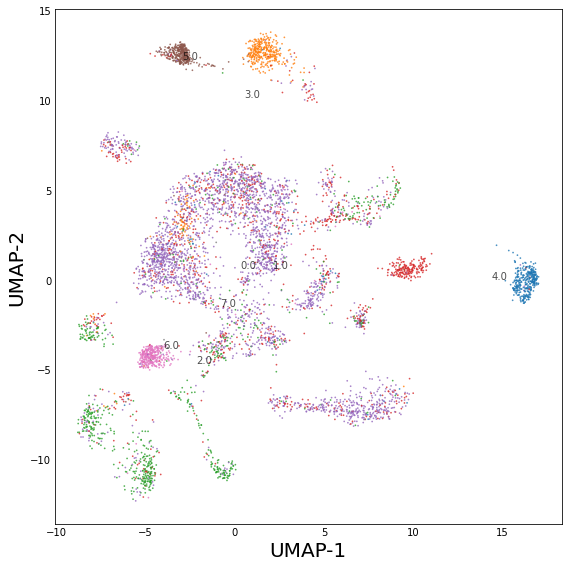

In [45]:
fig, axes = plt.subplots(figsize=(8, 8))
gene3c_cell = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C'].index
tmp = adata_merge[adata_merge.obs_names.isin(gene3c_cell)]
yi = tmp.obsm['u30_seuratcc30nofilter_u30_umap']
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, hue=cluster.loc[tmp.obs.index]['rnatype'], 
                palette = ccolor.to_dict()['Subclass.color'], legend = False)

### manually label point
representative_points = []
for cls in np.unique(cluster.loc[tmp.obs.index]['rnatype']):
    cluster_indices = np.where(cluster.loc[tmp.obs.index]['rnatype'] == cls)[0]
    centroid = np.mean(yi[cluster_indices], axis=0)
    representative_points.append(centroid)

for i, label in enumerate(np.unique(cluster.loc[tmp.obs.index]['rnatype'])):
    plt.annotate(label, (representative_points[i][0], representative_points[i][1]), fontsize=10, alpha=0.7)

axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('plot/match_droplethic_DPT_RNA_AllCooL_integration_hic_rna_annotation.pdf')fig, axes = plt.subplots(figsize=(8, 8))
gene3c_cell = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C'].index
tmp = adata_merge[adata_merge.obs_names.isin(gene3c_cell)]
yi = tmp.obsm['u30_seuratcc30nofilter_u30_umap']
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, hue=tmp.obs['leiden_08'].astype(str), legend = False)
### manually label point
representative_points = []
for cluster in np.unique(tmp.obs['leiden_08']):
    cluster_indices = np.where(tmp.obs['leiden_08'] == cluster)[0]
    centroid = np.mean(yi[cluster_indices], axis=0)
    representative_points.append(centroid)

for i, label in enumerate(np.unique(tmp.obs['leiden_08'].astype(str))):
    plt.annotate(label, (representative_points[i][0], representative_points[i][1]), fontsize=10, alpha=0.7)

axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('plot/match_droplethic_DPT_RNA_AllCooL_integration_hic.pdf')

## Cell types prediction

In [51]:
rna_cell = (adata_merge.obs['Modality']=='RNA')
hic_cell = (adata_merge.obs['Modality']=='3C')
print(rna_cell.sum(), hic_cell.sum())

import pynndescent
start_time = time.time()
index = pynndescent.NNDescent(adata_merge.obsm['X_pca'][rna_cell], metric='euclidean', n_neighbors=50, random_state=0, n_jobs=-1)
print(time.time() - start_time)
G, D = index.query(adata_merge.obsm['X_pca'][hic_cell], k=15)
print(time.time() - start_time)

22054 6235
3.977250814437866
6.805879354476929


In [52]:
chunk_size = 50000
sd = 1

### follow Jingtian's tutorial
### to prevent duplicated point appear
cellfilter = D[:, -1] == 0
D = 1 - D / D[:, -1][:, None]
D[cellfilter] = 1
D = 1 - np.exp(-D * (sd**2) / 4)
D = D / (np.sum(D, axis=1) + 1e-6)[:, None]

rna_cell = rna_cell.index[rna_cell]
hic_cell = hic_cell.index[hic_cell]

enc = OneHotEncoder()
# enc.fit(adata_merge.obs.loc[aibs_cell, ['L3']].values.astype(str))
labelref = enc.fit_transform(adata_merge.obs.loc[rna_cell, 'Anno0.8_yel'].astype(str)[:, None])
cluster = pd.DataFrame(index=hic_cell, columns=['rnatype', 'score'], dtype=str)
for chunk_start in range(0, len(hic_cell), chunk_size):
    result = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()]
        .toarray()
        .reshape((-1, 15, enc.categories_[0].shape[0]))
    ).sum(axis=1)
    result = pd.DataFrame(
        result,
        columns=enc.categories_[0],
        index=hic_cell[chunk_start : (chunk_start + chunk_size)],
    )
    result = result.loc[:, result.columns != "nan"]
    cluster.loc[result.index, "rnatype"] = result.idxmax(axis=1).values
    cluster.loc[result.index, "score"] = result.max(axis=1).values
    print(chunk_start)

print(time.time() - start_time)
cluster.to_hdf("droplethic_DPT_RNA_AllCooL_cluster.hdf", key="data")

/scratch/y2xie/34090333.tscc-mgr7.local/ipykernel_16433/2942845299.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  labelref = enc.fit_transform(adata_merge.obs.loc[rna_cell, 'Anno0.8_yel'].astype(str)[:, None])


0
7.028485059738159


## Plot predicted results (Fig.1D)

In [21]:
ccolor = pd.read_csv("../../../public_data/FC_RNA_Seurat_merged_rmScrublet_221229_Subclass.color.xls", sep = '\t', index_col=0)
ccolor.head()

,Subclass.color
OPC,#B9A0D6
OGC,#985695
ASC,#A13F9E
SSTGA,#48C899
ITL23GL,#E59D9F


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 29 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'five', 'four', 'hyphen', 'minus', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 36, 37, 38, 39, 42, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 29 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B',

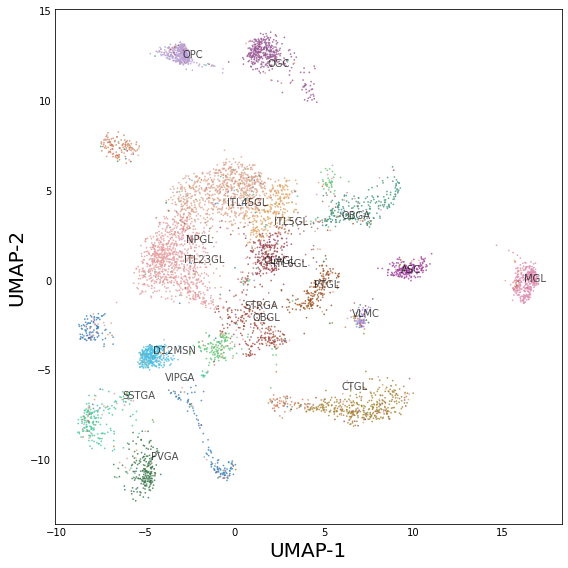

In [53]:
fig, axes = plt.subplots(figsize=(8, 8))
gene3c_cell = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C'].index
tmp = adata_merge[adata_merge.obs_names.isin(gene3c_cell)]
yi = tmp.obsm['u30_seuratcc30nofilter_u30_umap']
sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=axes, s=3, alpha=0.8, linewidth=0, hue=cluster.loc[tmp.obs.index]['rnatype'], 
                palette = ccolor.to_dict()['Subclass.color'], legend = False)

### manually label point
representative_points = []
for cls in np.unique(cluster.loc[tmp.obs.index]['rnatype']):
    cluster_indices = np.where(cluster.loc[tmp.obs.index]['rnatype'] == cls)[0]
    centroid = np.mean(yi[cluster_indices], axis=0)
    representative_points.append(centroid)

for i, label in enumerate(np.unique(cluster.loc[tmp.obs.index]['rnatype'])):
    plt.annotate(label, (representative_points[i][0], representative_points[i][1]), fontsize=10, alpha=0.7)

axes.set_xlabel('UMAP-1', fontsize=20)
axes.set_ylabel('UMAP-2', fontsize=20)
axes.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.savefig('plot/match_droplethic_DPT_RNA_AllCooL_integration_hic_rna_annotation.pdf')

## Check prediction accuracy

In [57]:
cluster['hictype'] = adata_merge.obs.loc[hic_cell, 'leiden_08'].astype(str)
adata_merge.obs.loc[hic_cell, 'Anno0.8_yel'] = cluster['rnatype']

<AxesSubplot:xlabel='score', ylabel='Count'>

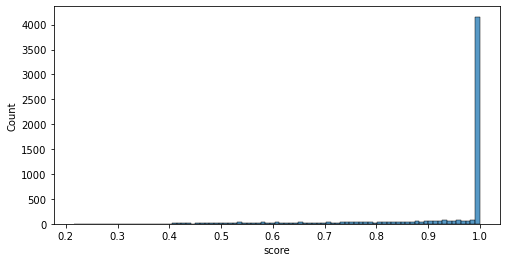

In [58]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(cluster['score'])